In [1]:
from __init__ import subject_number, path_data, path_model, model_name

import pandas as pd
import glob

# ファイルパスを取得
file_paths = glob.glob(path_data + '/*.csv')

# 認証したい方のパス
subject_path = 'out_no' + str(subject_number)

# 認証したい方のみのデータを抽出
user_file_paths = [file for file in file_paths if subject_path in file]
dfs_user = [pd.read_csv(file) for file in user_file_paths]
df_user = pd.concat(dfs_user, ignore_index=True)
df_d1 = pd.read_csv(path_data + '/' + subject_path + '_days' + str(1) + '.csv')
df_d2 = pd.read_csv(path_data + '/' + subject_path + '_days' + str(2) + '.csv')
df_d3 = pd.read_csv(path_data + '/' + subject_path + '_days' + str(3) + '.csv')
df_d4 = pd.read_csv(path_data + '/' + subject_path + '_days' + str(4) + '.csv')

# 認証対象以外のデータを抽出
allusers_file_paths = [file for file in file_paths if subject_path not in file]
dfs_all = [pd.read_csv(file) for file in allusers_file_paths]
df_all = pd.concat(dfs_all, ignore_index=True)
df_all['class'] = 99

ユーザの1日目のデータを利用してモデル生成

In [2]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.optimizers import Adam
import optuna
import pickle

# 1日目のデータを半分分ける．
df_d1_train, df_d1_test = train_test_split(df_d1, test_size=0.5, random_state=42)
# alldataをテストデータと分ける．
df_all_train, df_all_test = train_test_split(df_all, test_size=0.3, random_state=42)

# df_d1_trainとサンプリングしたdf_allを結合
df_train = pd.concat([df_d1_train, df_all_train], ignore_index=True)

# 訓練データ
X_train = df_train.iloc[:, 1:].apply(lambda x: (x - x.mean()) / x.std(), axis=0)
y_train = df_train['class'].apply(lambda x: 1 if x != subject_number else 0)

# テストデータ
df_test = pd.concat([df_d1_test, df_all_test], ignore_index=True)
X_test = df_test.iloc[:, 1:].apply(lambda x: (x - x.mean()) / x.std(), axis=0)
y_test = df_test['class'].apply(lambda x: 1 if x != subject_number else 0)

# 最適化する目的関数を定義
def objective(trial):
    # ハイパーパラメータのサンプリング
    units_layer1 = trial.suggest_int('units_layer1', 32, 128)  # 隠れ層1のユニット数
    units_layer2 = trial.suggest_int('units_layer2', 16, 64)   # 隠れ層2のユニット数
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)  # 学習率
    batch_size = trial.suggest_int('batch_size', 8, 64)  # バッチサイズ

    # モデル構成
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))  # 入力層
    model.add(Dense(units_layer1, activation='relu'))  # 隠れ層1
    model.add(Dense(units_layer2, activation='relu'))  # 隠れ層2
    model.add(Dense(1, activation='sigmoid'))  # 出力層

    # モデルのコンパイル
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # モデルの訓練
    history = model.fit(X_train, y_train, epochs=50, batch_size=batch_size, validation_split=0.2, verbose=0)
    
    # 最後のエポックでのvalidation accuracyを返す
    val_accuracy = history.history['val_accuracy'][-1]
    return val_accuracy

# Optunaのスタディを作成して最適化
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)  # 20回試行して最適化

# 最良のハイパーパラメータを表示
# print(f"Best trial: {study.best_trial.params}")

# 最良のハイパーパラメータでモデルを再構築し、訓練
best_params = study.best_trial.params
model = Sequential()
model.add(Input(shape=(X_train.shape[1],))) # 入力層
model.add(Dense(best_params['units_layer1'], activation='relu')) # 隠れ層1
model.add(Dense(best_params['units_layer2'], activation='relu')) # 隠れ層2
model.add(Dense(1, activation='sigmoid')) # 出力層

# 最良のモデルをコンパイル
optimizer = Adam(learning_rate=best_params['learning_rate'])
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# 最良のモデルで訓練
model.fit(X_train, y_train, epochs=50, batch_size=best_params['batch_size'], validation_split=0.2, verbose=0)

# モデルの保存
pickle.dump(model, open(path_model, 'wb'))

c:\Users\seksh\Downloads\python\jupyter\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-10-15 01:54:06,357] A new study created in memory with name: no-name-72925a4a-66a9-4dcf-8938-559ad1624634
[I 2024-10-15 01:54:15,424] Trial 0 finished with value: 1.0 and parameters: {'units_layer1': 124, 'units_layer2': 28, 'learning_rate': 0.006251402540748662, 'batch_size': 40}. Best is trial 0 with value: 1.0.
[I 2024-10-15 01:54:24,570] Trial 1 finished with value: 1.0 and parameters: {'units_layer1': 106, 'units_layer2': 48, 'learning_rate': 0.00016033715765780422, 'batch_size': 38}. Best is trial 0 with value: 1.0.
[I 2024-10-15 01:54:33,732] Trial 2 finished with value: 1.0 and parameters: {'units_layer1': 128, 'units_layer2': 24, 'learning_rate': 0.000905823949758445, 'batch_size': 47}. Best is trial 0 with val

日付ごとに精度の比較

In [5]:
from sklearn.metrics import classification_report, confusion_matrix

# 1日目のデータを半分分ける．
df_d1_train, df_d1_test = train_test_split(df_d1, test_size=0.5, random_state=42)
# alldataをテストデータと分ける．
df_all_train, df_all_test = train_test_split(df_all, test_size=0.2, random_state=42)

# モデルの読み込み
model = pickle.load(open(path_model, 'rb'))

# 1日目
df_test = pd.concat([df_d1_test, df_all_test], ignore_index=True) # 1日目の場合
X_test = df_test.iloc[:, 1:].apply(lambda x: (x - x.mean()) / x.std(), axis=0)
y_test = df_test['class'].apply(lambda x: 1 if x != subject_number else 0)
# モデルの評価
y_pred = (model.predict(X_test) > 0.5).astype("int32")  # 予測値を0または1に変換
# 評価結果の表示
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred)) # ラベルデータ：ユーザの場合0，ユーザ以外を1

# 2日目
df_test = pd.concat([df_d2, df_all_test], ignore_index=True) # 1日目の場合
X_test = df_test.iloc[:, 1:].apply(lambda x: (x - x.mean()) / x.std(), axis=0)
y_test = df_test['class'].apply(lambda x: 1 if x != subject_number else 0)
# モデルの評価
y_pred = (model.predict(X_test) > 0.5).astype("int32")  # 予測値を0または1に変換
# 評価結果の表示
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred)) # ラベルデータ：ユーザの場合0，ユーザ以外を1

#3日目
df_test = pd.concat([df_d3, df_all_test], ignore_index=True) # 1日目の場合
X_test = df_test.iloc[:, 1:].apply(lambda x: (x - x.mean()) / x.std(), axis=0)
y_test = df_test['class'].apply(lambda x: 1 if x != subject_number else 0)
# モデルの評価
y_pred = (model.predict(X_test) > 0.5).astype("int32")  # 予測値を0または1に変換
# 評価結果の表示
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred)) # ラベルデータ：ユーザの場合0，ユーザ以外を1

# 4日目
df_test = pd.concat([df_d4, df_all_test], ignore_index=True) # 1日目の場合
X_test = df_test.iloc[:, 1:].apply(lambda x: (x - x.mean()) / x.std(), axis=0)
y_test = df_test['class'].apply(lambda x: 1 if x != subject_number else 0)
# モデルの評価
y_pred = (model.predict(X_test) > 0.5).astype("int32")  # 予測値を0または1に変換
# 評価結果の表示
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred)) # ラベルデータ：ユーザの場合0，ユーザ以外を1


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000201E3C2BD80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
[[10  0]
 [ 0 55]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        55

    accuracy    

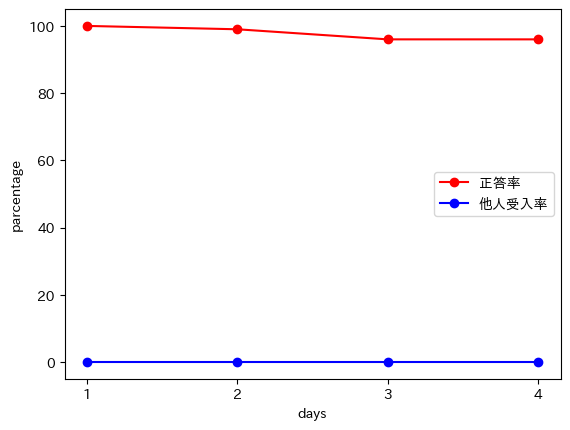

In [12]:
import numpy as np
import japanize_matplotlib
import matplotlib.pyplot as plt

x1 = [1, 2, 3, 4]
y2 = [0, 0, 0, 0]
y1 = [100, 99, 96, 96]

plt.plot(x1, y1, color = 'red', marker = 'o', label = "正答率")
plt.plot(x1, y2, color = 'blue', marker = 'o', label = "他人受入率")
plt.xlabel("days")
plt.ylabel("parcentage")
plt.xticks(np.arange(1,4.1,1))
plt.legend()
plt.show()


<br><br><br><br><br><br><br>ユーザデータ全ての認証精度

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Input
from sklearn.metrics import classification_report, confusion_matrix

# df_userとdf_allを縦方向に結合
df = pd.concat([df_user, df_all], ignore_index=True)

# 行列の標準化
dfs = df.iloc[:, 1:].apply(lambda x: (x - x.mean()) / x.std(), axis=0)

# 特徴量とラベルを分ける
X = dfs # 特徴量データ
y = df['class'].apply(lambda x: 1 if x != subject_number else 0)  # ラベルデータ

# データを訓練用とテスト用に分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))  # 入力層
model.add(Dense(64, activation='relu'))  # 隠れ層1
model.add(Dense(32, activation='relu'))  # 隠れ層2
model.add(Dense(1, activation='sigmoid'))  # 出力層

# モデルのコンパイル
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# モデルの訓練
model.fit(X_train, y_train, epochs=50, batch_size=10, validation_split=0.2, verbose=0)

# モデルの評価
y_pred = (model.predict(X_test) > 0.5).astype("int32")  # 予測値を0または1に変換

# 評価結果の表示
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))